# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task

We need the pathlib package for working with files and folders

In [2]:
from pathlib import Path

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We will use lenskit for training, running, and evaluating recommender algorithms

In [5]:
from lenskit import topn
from lenskit.metrics.predict import rmse

## Load Data

We specify the dataset we will use for our analysis and the main directory from where we read the recommendation and prediction files. From the main directory we find all the directories associated with the dataset and then read the recommendation and predictions files from those directories.

In [6]:
dataset = "ml100k"

In [7]:
output_root = Path("output")

In [9]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [14]:
recs = []
for fld in dirs: 
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file, sep=',')
        rec["dataset"] = fld.name.split("-")[0]
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'dataset': 'category', 'algorithm': 'category'})

In [18]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file, sep=',')
        pred["dataset"] = fld.name.split("-")[0]
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)

We need to load the test data so that we have the ground truths for computing accuracy 

In [19]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [20]:
test = []
for file in split_dir.glob("test-*.csv"):
    test.append(pd.read_csv(file, sep=','))

test = pd.concat(test, ignore_index=True)

## Compute Metrics

The topn.RecListAnalysis class computes top-N metrics for recommendation list and takes care of making sure that the recommendations and ground truths are properly matched. Refer to the documentation for detailed explanation of the purpose for the RecListAnalysis class and how the analysis is done - https://lkpy.lenskit.org/en/stable/evaluation/topn-metrics.html 

In [21]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

nrecs  precision  recip_rank  ndcg  ntruth
dataset algorithm user                                            
ml100k  ALS       1     100.0        0.0         0.0   0.0       5
                  2     100.0        0.0         0.0   0.0       5
                  3     100.0        0.0         0.0   0.0       5
                  4     100.0        0.0         0.0   0.0       5
                  5     100.0        0.0         0.0   0.0       5

We will reshape the 'results' dataframe by stacking the columns to index and then use the bar chart to visualize the performance of our algorithms with respect to the precision, reciprocal rank and ndcg metrics

In [22]:
pltData = (results.drop(columns=['nrecs']).stack()).reset_index().drop(columns=['dataset'])
pltData.columns = ['user', 'algorithm','metric', 'val']
pltData.head()

,user,algorithm,metric,val
0,ALS,1,precision,0.0
1,ALS,1,recip_rank,0.0
2,ALS,1,ndcg,0.0
3,ALS,1,ntruth,5.0
4,ALS,2,precision,0.0


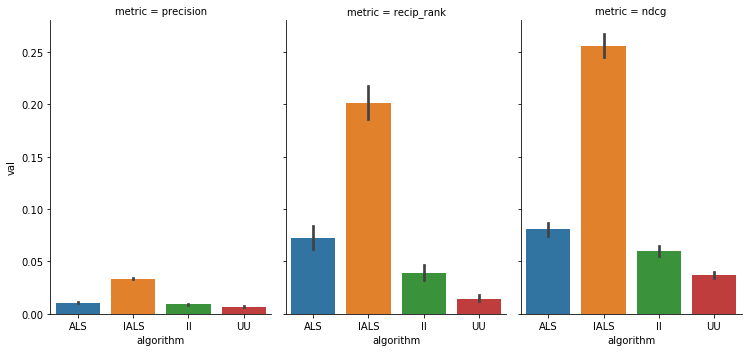

In [16]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=.7)

# ndcg   

# precision   

# recip_rank